In [1]:
# Install necessary libraries quietly (-q)
!pip install pandas numpy scikit-learn lightgbm matplotlib hijri-converter -q

In [2]:
# Import all required modules for data handling, modeling, and utilities
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
from datetime import timedelta, datetime
from hijri_converter import convert, Hijri, Gregorian

warnings.filterwarnings('ignore', category=UserWarning)
print("Libraries imported.")

Libraries imported.


In [3]:
# Define consistent column names, file paths, date ranges, and categorical features list
DATE_COLUMN = 'Week_Start_Date'
SKU_COLUMN = 'SKU'
TARGET_COLUMN = 'Target_Weekly_Quantity_Needed'
CATEGORICAL_FEATURES = ['Item_Category', 'Unit_of_Measure']
START_DATE = "2021-01-01"
END_DATE = "2024-12-31"

# --- Configuration for File Paths ---
# Adjust this path based on where your files are in Google Drive or Colab session
DRIVE_PATH = "/content/drive/MyDrive/DAFZA hackathon/data2/" # Change path as needed
# If uploaded directly to session storage, use: DRIVE_PATH = "/content/"
PRODUCTS_CSV = DRIVE_PATH + "products.csv"
WEEKLY_OPERATIONAL_CSV = DRIVE_PATH + "weekly_operational_data.csv"
WEEKLY_DEMAND_CSV = DRIVE_PATH + "weekly_demand.csv"

print("Configuration set.")

Configuration set.


In [5]:
# Define helper functions to calculate UAE holidays and check date conditions (Ramadan, Eid)
def get_uae_public_holidays(year):
    holidays = set()
    holidays.add(datetime(year, 1, 1).date()); holidays.add(datetime(year, 12, 1).date()); holidays.add(datetime(year, 12, 2).date()); holidays.add(datetime(year, 12, 3).date())
    hijri_year_approx = year - (2024 - 1445)
    try: h_fitr_start = Hijri(hijri_year_approx, 10, 1); g_fitr_start_obj = h_fitr_start.to_gregorian(); eid_fitr_g = datetime(g_fitr_start_obj.year, g_fitr_start_obj.month, g_fitr_start_obj.day).date(); holidays.add(eid_fitr_g); holidays.add(eid_fitr_g + timedelta(days=1)); holidays.add(eid_fitr_g + timedelta(days=2))
    except (ValueError, OverflowError) as e: print(f"Warn: Eid Fitr calc fail {year}: {e}")
    try: h_arafat = Hijri(hijri_year_approx, 12, 9); g_arafat_obj = h_arafat.to_gregorian(); arafat_g = datetime(g_arafat_obj.year, g_arafat_obj.month, g_arafat_obj.day).date(); holidays.add(arafat_g); h_adha_start = Hijri(hijri_year_approx, 12, 10); g_adha_start_obj = h_adha_start.to_gregorian(); eid_adha_g = datetime(g_adha_start_obj.year, g_adha_start_obj.month, g_adha_start_obj.day).date(); holidays.add(eid_adha_g); holidays.add(eid_adha_g + timedelta(days=1)); holidays.add(eid_adha_g + timedelta(days=2))
    except (ValueError, OverflowError) as e: print(f"Warn: Eid Adha calc fail {year}: {e}")
    return holidays
uae_holidays = set()
for year in range(int(START_DATE[:4]), int(END_DATE[:4]) + 2): uae_holidays.update(get_uae_public_holidays(year))
def get_ramadan_dates(year):
    hijri_year_approx = year - (2024 - 1445)
    try: h_ramadan_start = Hijri(hijri_year_approx, 9, 1); g_ramadan_start_obj = h_ramadan_start.to_gregorian(); ramadan_start = datetime(g_ramadan_start_obj.year, g_ramadan_start_obj.month, g_ramadan_start_obj.day).date(); h_ramadan_end_29 = Hijri(hijri_year_approx, 9, 29); g_ramadan_end_29_obj = h_ramadan_end_29.to_gregorian(); ramadan_end_29 = datetime(g_ramadan_end_29_obj.year, g_ramadan_end_29_obj.month, g_ramadan_end_29_obj.day).date(); return ramadan_start, ramadan_end_29
    except (ValueError, OverflowError) as e: print(f"Warn: Ramadan calc fail {year}: {e}"); return None, None
ramadan_periods = {}
for year in range(int(START_DATE[:4]) -1, int(END_DATE[:4]) + 2): ramadan_periods[year] = get_ramadan_dates(year)
def is_in_ramadan(date_obj):
    current_date = date_obj.date() if isinstance(date_obj, datetime) else date_obj
    for year in [current_date.year, current_date.year - 1]:
        if year in ramadan_periods and ramadan_periods[year][0] is not None: start, end = ramadan_periods[year];
        if start <= current_date <= end: return True
    return False
def check_holiday_in_week(start_date, holiday_set):
    for i in range(7):
        if (start_date + timedelta(days=i)).date() in holiday_set: return 1
    return 0
def check_eid_in_week(start_date):
    year = start_date.year
    hijri_year_approx = year - (2024-1445)
    try:
        h_fitr_start = Hijri(hijri_year_approx, 10, 1); g_fitr_start_obj = h_fitr_start.to_gregorian()
        eid_fitr_start_date = datetime(g_fitr_start_obj.year, g_fitr_start_obj.month, g_fitr_start_obj.day).date()
        h_adha_start = Hijri(hijri_year_approx, 12, 10); g_adha_start_obj = h_adha_start.to_gregorian()
        eid_adha_start_date = datetime(g_adha_start_obj.year, g_adha_start_obj.month, g_adha_start_obj.day).date()
        week_dates_set = set([(start_date + timedelta(days=d)).date() for d in range(7)])
        if eid_fitr_start_date in week_dates_set or eid_adha_start_date in week_dates_set: return 1
    except (ValueError, OverflowError): pass
    return 0
print("Helper functions defined.")

Helper functions defined.


In [7]:
# Load the three datasets (products, operational context, weekly demand) from CSV files
print("Loading datasets...")
try:
    # Optional: Mount Google Drive if files are there
    # from google.colab import drive
    # drive.mount('/content/drive')

    products_df = pd.read_csv(PRODUCTS_CSV)
    ops_df = pd.read_csv(WEEKLY_OPERATIONAL_CSV, parse_dates=[DATE_COLUMN])
    demand_df = pd.read_csv(WEEKLY_DEMAND_CSV, parse_dates=[DATE_COLUMN])
    print("Datasets loaded successfully.")
    print(f"Products shape: {products_df.shape}")
    print(f"Operational data shape: {ops_df.shape}")
    print(f"Demand data shape: {demand_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print(f"Please ensure files exist at the specified path: {DRIVE_PATH}")
    # Consider stopping execution if files aren't found
    # raise e
except Exception as e:
    print(f"An error occurred during file loading: {e}")
    # raise e

Loading datasets...
Datasets loaded successfully.
Products shape: (50, 8)
Operational data shape: (209, 21)
Demand data shape: (10250, 8)


In [8]:
# Combine the loaded DataFrames into a single DataFrame for modeling
print("Merging datasets...")
merged_df = pd.merge(demand_df, ops_df, on=DATE_COLUMN, how='left')
product_features_df = products_df[[SKU_COLUMN, 'Item_Category', 'Unit_of_Measure',
                                   'Avg_Unit_Cost_Base', 'Min_Order_Quantity',
                                   'Shelf_Life_Days', 'Supplier_Lead_Time_Days']].copy()
final_df = pd.merge(merged_df, product_features_df, on=SKU_COLUMN, how='left')
print(f"Data merged. Final DataFrame shape: {final_df.shape}")
# print(final_df.head()) # Optional: View merged data

Merging datasets...
Data merged. Final DataFrame shape: (10250, 34)


In [9]:
# Combine the loaded DataFrames into a single DataFrame for modeling
print("Merging datasets...")
merged_df = pd.merge(demand_df, ops_df, on=DATE_COLUMN, how='left')
product_features_df = products_df[[SKU_COLUMN, 'Item_Category', 'Unit_of_Measure',
                                   'Avg_Unit_Cost_Base', 'Min_Order_Quantity',
                                   'Shelf_Life_Days', 'Supplier_Lead_Time_Days']].copy()
final_df = pd.merge(merged_df, product_features_df, on=SKU_COLUMN, how='left')
print(f"Data merged. Final DataFrame shape: {final_df.shape}")
# print(final_df.head()) # Optional: View merged data

Merging datasets...
Data merged. Final DataFrame shape: (10250, 34)


In [10]:
# Prepare data for modeling: handle missing values and encode categorical features
print("Preparing data for modeling...")
final_df[DATE_COLUMN] = pd.to_datetime(final_df[DATE_COLUMN])

# Fill NAs in lags and other numeric columns
numeric_cols_with_lags = ['Needed_Qty_Lag_1W', 'Needed_Qty_Lag_2W', 'Needed_Qty_Lag_4W', 'Avg_Needed_Qty_Last_4W']
for col in numeric_cols_with_lags:
    if col in final_df.columns: final_df[col] = final_df[col].fillna(0)
numeric_cols = final_df.select_dtypes(include=np.number).columns.tolist()
final_df[numeric_cols] = final_df[numeric_cols].fillna(0)

# Encode specified categorical features using one-hot encoding
print(f"Encoding categorical features: {CATEGORICAL_FEATURES}")
existing_categorical = [col for col in CATEGORICAL_FEATURES if col in final_df.columns]
if existing_categorical:
    final_df = pd.get_dummies(final_df, columns=existing_categorical, drop_first=True, dummy_na=False)
    print("Categorical features encoded.")
else:
    print("No specified categorical features found to encode.")
# print(final_df.info()) # Optional: Check data types after encoding

Preparing data for modeling...
Encoding categorical features: ['Item_Category', 'Unit_of_Measure']
Categorical features encoded.


In [11]:
# Separate the features (input variables) from the target variable (what to predict)
features_to_exclude = [ DATE_COLUMN, SKU_COLUMN, 'Item_Name', TARGET_COLUMN, 'Avg_Unit_Cost_Base' ]
features_to_exclude = [col for col in features_to_exclude if col in final_df.columns]
feature_columns = [col for col in final_df.columns if col not in features_to_exclude]

X = final_df[feature_columns]
y = final_df[TARGET_COLUMN]

print(f"Features selected ({len(feature_columns)}): {feature_columns[:5]}...")
print(f"Target variable: {TARGET_COLUMN}")
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

Features selected (61): ['Avg_Unit_Cost', 'Needed_Qty_Lag_1W', 'Needed_Qty_Lag_2W', 'Needed_Qty_Lag_4W', 'Avg_Needed_Qty_Last_4W']...
Target variable: Target_Weekly_Quantity_Needed
Shape of X: (10250, 61), Shape of y: (10250,)


In [12]:
# Split data into training, validation, and test sets while preserving time order
print("Splitting data chronologically...")
final_df = final_df.sort_values(by=DATE_COLUMN)
X = final_df[feature_columns] # Reassign X after sorting
y = final_df[TARGET_COLUMN]   # Reassign y after sorting

if len(final_df) < 10: raise ValueError("Not enough data points for splitting.")

train_size_idx = int(len(final_df) * 0.70)
val_size_idx = int(len(final_df) * 0.15)

X_train, y_train = X[:train_size_idx], y[:train_size_idx]
X_val, y_val = X[train_size_idx : train_size_idx + val_size_idx], y[train_size_idx : train_size_idx + val_size_idx]
X_test, y_test = X[train_size_idx + val_size_idx:], y[train_size_idx + val_size_idx:]

# Store identifiers for the test set for later analysis
test_dates = final_df.iloc[train_size_idx + val_size_idx:][DATE_COLUMN]
test_skus = final_df.iloc[train_size_idx + val_size_idx:][SKU_COLUMN]

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Splitting data chronologically...
Train set size: 7174
Validation set size: 1537
Test set size: 1539


In [13]:
# Train the LightGBM regression model with early stopping using the validation set
print("Training LightGBM model...")
lgbm = lgb.LGBMRegressor(
    objective='regression_l1', metric='mae', n_estimators=1000, learning_rate=0.05,
    num_leaves=31, max_depth=-1, min_child_samples=20, subsample=0.8,
    colsample_bytree=0.8, random_state=42, n_jobs=-1
)

if not X_val.empty:
    print("Training with early stopping...")
    lgbm.fit( X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mae',
              callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=10)])
else:
    print("Validation set empty. Training without early stopping.")
    lgbm.fit(X_train, y_train)
print("Model training complete.")

Training LightGBM model...
Training with early stopping...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3222
[LightGBM] [Info] Number of data points in the train set: 7174, number of used features: 61
[LightGBM] [Info] Start training from score 189.100006
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 14.535
Model training complete.


In [14]:
# Evaluate the trained model's performance on the unseen test set using standard metrics
print("\n--- Model Verification ---")
if X_test.empty:
    print("Test set is empty. Skipping evaluation.")
else:
    print("Evaluating model on the test set...")
    test_preds = lgbm.predict(X_test)
    test_preds[test_preds < 0] = 0 # Ensure non-negative

    mae = mean_absolute_error(y_test, test_preds)
    try: # Use newer RMSE function if available
        from sklearn.metrics import root_mean_squared_error
        rmse = root_mean_squared_error(y_test, test_preds)
    except ImportError: # Fallback for older sklearn versions
        rmse = mean_squared_error(y_test, test_preds, squared=False)

    mask = y_test > 0.1 # Avoid division by zero/small numbers for MAPE
    mape = np.mean(np.abs((y_test[mask] - test_preds[mask]) / y_test[mask])) * 100 if np.any(mask) else 0

    print(f"\nTest Set Performance:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}% (for actuals > 0.1)")

    # Create results DataFrame for analysis
    results_df = pd.DataFrame({ DATE_COLUMN: test_dates.values, SKU_COLUMN: test_skus.values,
                               'Actual_Needed': y_test.values, 'Predicted_Needed': test_preds })
    results_df['Absolute_Error'] = abs(results_df['Actual_Needed'] - results_df['Predicted_Needed'])
    results_df['Percentage_Error'] = np.where(results_df['Actual_Needed'] > 0.1, (results_df['Absolute_Error'] / results_df['Actual_Needed']) * 100, 0)

    print("\nSample Predictions vs Actuals:")
    print(results_df.head(10))
    print("\nWorst Predictions (Highest Absolute Error):")
    print(results_df.sort_values(by='Absolute_Error', ascending=False).head(10))


--- Model Verification ---
Evaluating model on the test set...

Test Set Performance:
  Mean Absolute Error (MAE): 11.7444
  Root Mean Squared Error (RMSE): 26.2429
  Mean Absolute Percentage Error (MAPE): 5.02% (for actuals > 0.1)

Sample Predictions vs Actuals:
  Week_Start_Date      SKU  Actual_Needed  Predicted_Needed  Absolute_Error  \
0      2024-06-02  SKU1000         104.56        108.025063        3.465063   
1      2024-06-02  SKU1016          23.96         25.175468        1.215468   
2      2024-06-02  SKU1002          45.54         46.017162        0.477162   
3      2024-06-02  SKU1015         501.89        539.349151       37.459151   
4      2024-06-02  SKU1024          61.40         64.211760        2.811760   
5      2024-06-02  SKU1003           8.72          9.578089        0.858089   
6      2024-06-02  SKU1023          92.67         91.540506        1.129494   
7      2024-06-02  SKU1031         212.41        212.822958        0.412958   
8      2024-06-02  SKU10

In [15]:
# Display the most important features as determined by the LightGBM model
print("\nFeature Importances:")
if 'lgbm' in locals() and hasattr(lgbm, 'feature_importances_'):
    # Use feature_name_ if available from LightGBM model object
    f_names = lgbm.feature_name_ if hasattr(lgbm, 'feature_name_') and lgbm.feature_name_ else X.columns # Fallback
    if len(lgbm.feature_importances_) == len(f_names):
         feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, f_names)), columns=['Value','Feature'])
         feature_imp = feature_imp.sort_values(by="Value", ascending=False)
         print(feature_imp.head(20)) # Print top 20 features
    else:
         print(f"Warning: Mismatch between feature importance count ({len(lgbm.feature_importances_)}) and feature name count ({len(f_names)}). Using X.columns as fallback.")
         if len(lgbm.feature_importances_) == len(X.columns):
              feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, X.columns)), columns=['Value','Feature'])
              feature_imp = feature_imp.sort_values(by="Value", ascending=False)
              print(feature_imp.head(20))
         else:
              print("Error: Cannot determine feature names reliably.")

else:
    print("Model object 'lgbm' not found or feature importances not available.")


Feature Importances:
    Value                       Feature
60   3082             Needed_Qty_Lag_1W
59   2730                 Avg_Unit_Cost
58   2240             Needed_Qty_Lag_4W
57   2238             Needed_Qty_Lag_2W
56   2047        Avg_Needed_Qty_Last_4W
55   1423       Forecasted_Event_Guests
54   1340  Forecasted_Occupancy_Percent
53   1220           Percent_Guests_Asia
52   1208            Percent_Guests_GCC
51   1075              Percent_Families
50   1003         Percent_Guests_Europe
49    960       Percent_Guests_Americas
47    910   Percent_Guests_Other_Region
48    910               Shelf_Life_Days
46    898      Percent_Guests_Africa_ME
45    872          Percent_Guests_Group
44    830       Percent_Guests_Business
43    805                  Week_of_Year
42    785        Percent_Guests_Leisure
41    609       Supplier_Lead_Time_Days



Generating prediction plots for sample SKUs...
Plots saved to prediction_plots.png


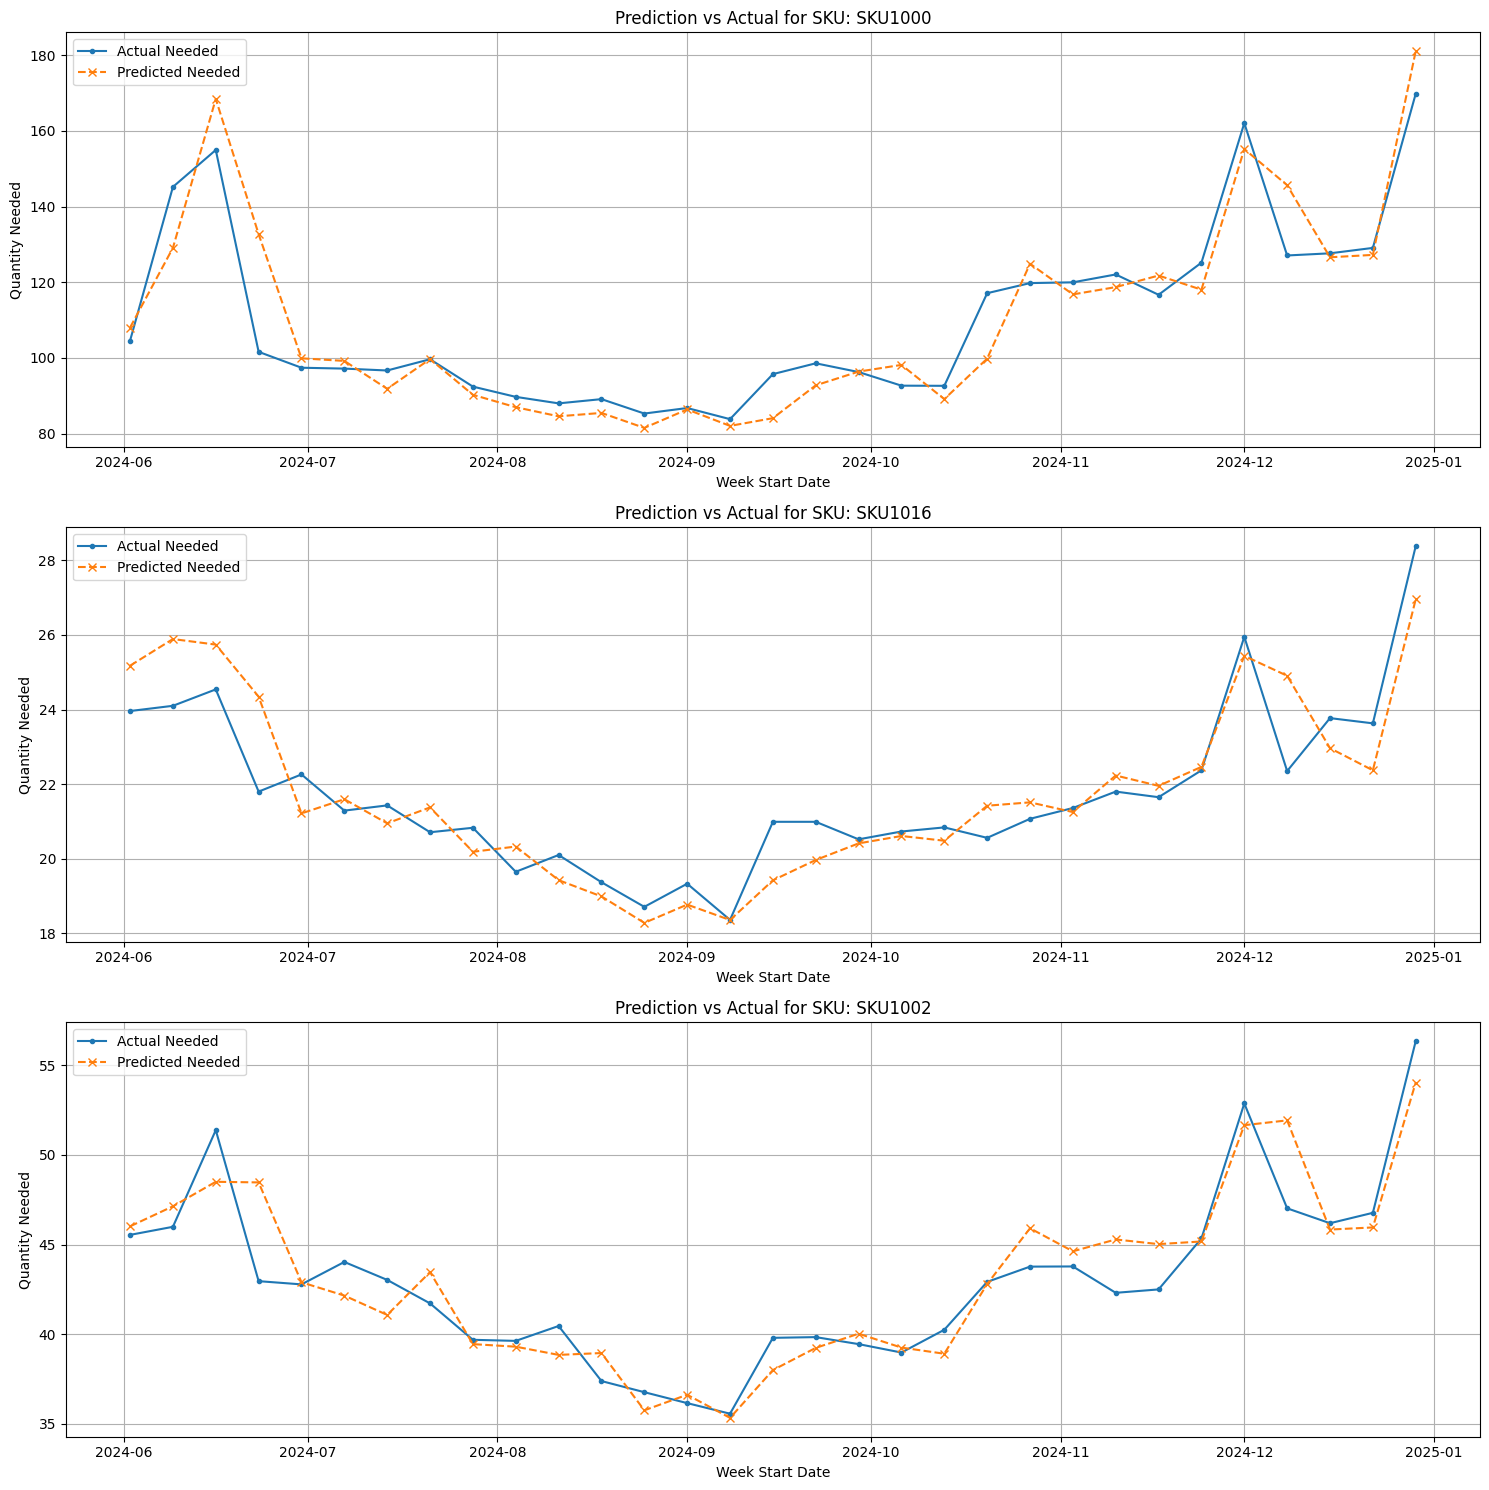

In [16]:
# Generate and save plots comparing actual vs predicted values for a few sample SKUs
print("\nGenerating prediction plots for sample SKUs...")
if 'results_df' in locals() and not results_df.empty:
    skus_to_plot = results_df[SKU_COLUMN].unique()[:3]
    if len(skus_to_plot) > 0:
        plt.figure(figsize=(15, 5 * len(skus_to_plot)))
        for i, sku in enumerate(skus_to_plot):
            plt.subplot(len(skus_to_plot), 1, i+1)
            sku_data = results_df[results_df[SKU_COLUMN] == sku].sort_values(by=DATE_COLUMN)
            if not sku_data.empty:
                plt.plot(sku_data[DATE_COLUMN], sku_data['Actual_Needed'], label='Actual Needed', marker='.', linestyle='-')
                plt.plot(sku_data[DATE_COLUMN], sku_data['Predicted_Needed'], label='Predicted Needed', marker='x', linestyle='--')
                plt.title(f'Prediction vs Actual for SKU: {sku}')
                plt.xlabel('Week Start Date'); plt.ylabel('Quantity Needed'); plt.legend(); plt.grid(True)
            else: plt.title(f'No data to plot for SKU: {sku}')
        plt.tight_layout()
        plt.savefig("prediction_plots.png") # Saves the plot in the Colab environment
        print("Plots saved to prediction_plots.png")
        # plt.show() # Uncomment to display plot directly below the cell
    else: print("No unique SKUs found in the test set results to plot.")
else: print("Skipping plots because test evaluation results are not available.")

In [19]:
# Define the function to predict future demand and calculate order quantities
print("\n--- Defining Order Prediction Function ---")
def predict_and_suggest_orders(
    model, future_ops_data: pd.DataFrame, latest_demand_hist: pd.DataFrame,
    products_info: pd.DataFrame, current_stock: pd.DataFrame,
    categorical_features_list: list, training_cols: list ):
    """ Predicts demand for the next week(s) and suggests order quantities. """
    print("\nStarting prediction for future week(s)...")
    # --- Input Checks ---
    if future_ops_data.empty or latest_demand_hist.empty or products_info.empty or current_stock.empty: print("Error: One or more input DataFrames are empty."); return pd.DataFrame()
    required_product_cols = [SKU_COLUMN, 'Item_Category', 'Unit_of_Measure', 'Avg_Unit_Cost_Base', 'Min_Order_Quantity']; required_stock_cols = [SKU_COLUMN, 'Current_Stock_Level']; required_hist_cols = [DATE_COLUMN, SKU_COLUMN, TARGET_COLUMN]; required_ops_cols = [DATE_COLUMN]
    if not all(col in products_info.columns for col in required_product_cols): print(f"Error: products_info missing required columns."); return pd.DataFrame()
    if not all(col in current_stock.columns for col in required_stock_cols): print(f"Error: current_stock missing required columns."); return pd.DataFrame()
    if not all(col in latest_demand_hist.columns for col in required_hist_cols): print(f"Error: latest_demand_hist missing required columns."); return pd.DataFrame()
    if not all(col in future_ops_data.columns for col in required_ops_cols): print(f"Error: future_ops_data missing required columns."); return pd.DataFrame()

    # --- Prepare features ---
    future_ops_data[DATE_COLUMN] = pd.to_datetime(future_ops_data[DATE_COLUMN]); latest_demand_hist[DATE_COLUMN] = pd.to_datetime(latest_demand_hist[DATE_COLUMN])
    prediction_features = future_ops_data.copy()
    latest_demand_hist = latest_demand_hist.sort_values(by=[SKU_COLUMN, DATE_COLUMN]); sku_list = products_info[SKU_COLUMN].unique(); lag_features_list = []
    for sku in sku_list:
        sku_hist = latest_demand_hist[latest_demand_hist[SKU_COLUMN] == sku].tail(4)
        if len(sku_hist) < 1: lag_1w, lag_2w, lag_4w, avg_4w = 0, 0, 0, 0
        else: lag_1w = sku_hist[TARGET_COLUMN].iloc[-1] if len(sku_hist) >= 1 else 0; lag_2w = sku_hist[TARGET_COLUMN].iloc[-2] if len(sku_hist) >= 2 else 0; lag_4w = sku_hist[TARGET_COLUMN].iloc[-4] if len(sku_hist) >= 4 else 0; avg_4w = sku_hist[TARGET_COLUMN].mean()
        lag_features_list.append({ SKU_COLUMN: sku, 'Needed_Qty_Lag_1W': lag_1w, 'Needed_Qty_Lag_2W': lag_2w, 'Needed_Qty_Lag_4W': lag_4w, 'Avg_Needed_Qty_Last_4W': avg_4w })
    lag_features_df = pd.DataFrame(lag_features_list)
    sku_df_template = products_info[[SKU_COLUMN, 'Item_Category', 'Unit_of_Measure', 'Avg_Unit_Cost_Base', 'Supplier_Lead_Time_Days', 'Min_Order_Quantity', 'Shelf_Life_Days']].copy()
    prediction_features = prediction_features.merge(sku_df_template, how='cross')
    prediction_features = pd.merge(prediction_features, lag_features_df, on=SKU_COLUMN, how='left')
    prediction_features[numeric_cols_with_lags] = prediction_features[numeric_cols_with_lags].fillna(0) # Use global list name
    prediction_features['Avg_Unit_Cost'] = prediction_features['Avg_Unit_Cost_Base']
    if 'Avg_Unit_Cost_Base' not in training_cols: prediction_features = prediction_features.drop(columns=['Avg_Unit_Cost_Base'], errors='ignore')
    existing_categorical_pred = [col for col in categorical_features_list if col in prediction_features.columns]
    if existing_categorical_pred: prediction_features = pd.get_dummies(prediction_features, columns=existing_categorical_pred, drop_first=True, dummy_na=False)

    # Store Identifiers BEFORE aligning
    if DATE_COLUMN not in prediction_features.columns or SKU_COLUMN not in prediction_features.columns: print(f"CRITICAL Error: Identifiers missing before alignment."); return pd.DataFrame()
    identifiers = prediction_features[[DATE_COLUMN, SKU_COLUMN]].copy()

    # Align columns
    print(f"Aligning prediction columns with {len(training_cols)} training columns...")
    X_pred = pd.DataFrame(columns=training_cols, index=prediction_features.index)
    present_cols = prediction_features.columns
    for col in training_cols:
        if col in present_cols: X_pred[col] = prediction_features[col]
        else: X_pred[col] = 0

    # Make Predictions
    print(f"Predicting demand for {len(X_pred)} SKU-Week combinations...")
    predicted_needs = model.predict(X_pred)
    predicted_needs[predicted_needs < 0] = 0

    # Prepare Output
    output_df = identifiers; output_df['Predicted_Need'] = predicted_needs
    output_df = pd.merge(output_df, current_stock, on=SKU_COLUMN, how='left'); output_df['Current_Stock_Level'] = output_df['Current_Stock_Level'].fillna(0)
    if SKU_COLUMN not in products_info.columns: print(f"Error: '{SKU_COLUMN}' missing from products_info for MOQ merge."); return pd.DataFrame()
    output_df = pd.merge(output_df, products_info[[SKU_COLUMN, 'Min_Order_Quantity']], on=SKU_COLUMN, how='left'); output_df['Min_Order_Quantity'] = output_df['Min_Order_Quantity'].fillna(1)
    output_df['Calculated_Need_Vs_Stock'] = output_df['Predicted_Need'] - output_df['Current_Stock_Level']
    output_df['Suggested_Order_Qty'] = output_df['Calculated_Need_Vs_Stock'].apply(lambda x: max(0, np.ceil(x) if x > 0.1 else np.round(x,2) ) )

    print("Order suggestions generated.")
    return output_df[[DATE_COLUMN, SKU_COLUMN, 'Predicted_Need', 'Current_Stock_Level', 'Calculated_Need_Vs_Stock', 'Min_Order_Quantity', 'Suggested_Order_Qty']]

print("Prediction function defined.")


--- Defining Order Prediction Function ---
Prediction function defined.


In [21]:
# Prepare example inputs (future operational forecast, recent history, current stock) for the prediction function
print("\n--- Preparing Example Inputs for Order Prediction ---")
if 'final_df' in locals() and not final_df.empty and train_size_idx + val_size_idx < len(final_df):
    last_historical_date = final_df.iloc[-1][DATE_COLUMN]
    next_week_start = last_historical_date + timedelta(weeks=1)
    print(f"Predicting for week starting: {next_week_start.date()}")

    # DUMMY FUTURE OPS DATA - REPLACE WITH ACTUAL FORECASTS
    dummy_future_ops = pd.DataFrame([{
        DATE_COLUMN: next_week_start, 'Forecasted_Occupancy_Percent': 75.0, 'Forecasted_Event_Guests': 180,
        'Week_of_Year': next_week_start.isocalendar()[1], 'Month': next_week_start.month,
        'Is_Peak_Season': 1 if next_week_start.month in [11, 12, 1, 2, 3] else 0,
        'Is_Low_Season': 1 if next_week_start.month in [6, 7, 8] else 0,
        'Is_Ramadan_Week': 1 if is_in_ramadan(next_week_start) else 0,
        'Is_Eid_Week': check_eid_in_week(next_week_start),
        'Is_Public_Holiday_Week': check_holiday_in_week(next_week_start, uae_holidays),
        'Percent_Guests_GCC': 30.0, 'Percent_Guests_Europe': 35.0, 'Percent_Guests_Asia': 15.0,
        'Percent_Guests_Americas': 5.0, 'Percent_Guests_Africa_ME': 10.0, 'Percent_Guests_Other_Region': 5.0,
        'Percent_Guests_Leisure': 65.0, 'Percent_Guests_Business': 25.0, 'Percent_Guests_Group': 10.0,
        'Percent_Families': 28.0, 'Percent_Adult_Only_Bookings': 72.0
    }])
    dummy_future_ops[DATE_COLUMN] = pd.to_datetime(dummy_future_ops[DATE_COLUMN])

    # LATEST HISTORICAL DEMAND - USE REAL DATA UP TO THE PREDICTION POINT
    latest_hist = final_df[final_df[DATE_COLUMN] <= last_historical_date].sort_values(by=DATE_COLUMN).groupby(SKU_COLUMN).tail(4)
    latest_hist = latest_hist[[DATE_COLUMN, SKU_COLUMN, TARGET_COLUMN]].copy()

    # DUMMY CURRENT STOCK - REPLACE WITH ACTUAL INVENTORY LEVELS
    dummy_stock_list = []
    all_skus = products_df[SKU_COLUMN].unique()
    for sku in all_skus:
        last_hist_sku = latest_hist[latest_hist[SKU_COLUMN] == sku]
        last_need = last_hist_sku[TARGET_COLUMN].iloc[-1] if not last_hist_sku.empty else 0
        stock_level = max(0, np.random.normal(last_need * 0.5, last_need * 0.15))
        dummy_stock_list.append({SKU_COLUMN: sku, 'Current_Stock_Level': round(stock_level, 2)})
    dummy_current_stock = pd.DataFrame(dummy_stock_list)

    print("Example Inputs Prepared.")
    # print(dummy_future_ops.head()) # Optional: view inputs
    # print(latest_hist.head())
    # print(dummy_current_stock.head())

else:
    print("Error: Cannot prepare example data. Previous steps might have failed or dataset is too small.")
    dummy_future_ops = pd.DataFrame(); latest_hist = pd.DataFrame(); dummy_current_stock = pd.DataFrame()
    order_suggestions = pd.DataFrame() # Define as empty to prevent errors


--- Preparing Example Inputs for Order Prediction ---
Predicting for week starting: 2025-01-05
Example Inputs Prepared.


In [22]:
# Run the prediction function with the prepared inputs and display/save the suggested order quantities
if ( 'lgbm' in locals() and 'products_df' in locals() and not products_df.empty and
     'feature_columns' in locals() and # This holds the list used for training X
     not dummy_future_ops.empty and not latest_hist.empty and not dummy_current_stock.empty):
    print("\n--- Running Order Suggestion Function ---")

    # Use the feature_columns list determined during training prep (Cell 8)
    order_suggestions = predict_and_suggest_orders(
        model=lgbm, future_ops_data=dummy_future_ops, latest_demand_hist=latest_hist,
        products_info=products_df, current_stock=dummy_current_stock,
        categorical_features_list=CATEGORICAL_FEATURES, training_cols=feature_columns )

    # Display results
    print("\n--- Order Suggestions for Next Week ---")
    if order_suggestions is not None and not order_suggestions.empty:
        print(order_suggestions[order_suggestions['Suggested_Order_Qty'] > 0].head(20))
        suggestions_csv = DRIVE_PATH + "order_suggestions_next_week.csv" # Save to Drive path
        order_suggestions.to_csv(suggestions_csv, index=False, date_format='%Y-%m-%d')
        print(f"\nOrder suggestions saved to {suggestions_csv}")
    else: print("Could not generate order suggestions.")
else: print("Skipping order suggestion example because required data or model is missing.")

print("\nScript finished.")


--- Running Order Suggestion Function ---

Starting prediction for future week(s)...
Aligning prediction columns with 61 training columns...
Predicting demand for 50 SKU-Week combinations...
Order suggestions generated.

--- Order Suggestions for Next Week ---
   Week_Start_Date      SKU  Predicted_Need  Current_Stock_Level  \
0       2025-01-05  SKU1000      143.891775                50.23   
1       2025-01-05  SKU1001      260.504886               166.69   
2       2025-01-05  SKU1002       51.067181                34.71   
3       2025-01-05  SKU1003       10.352769                 8.43   
4       2025-01-05  SKU1004      580.413706               403.03   
6       2025-01-05  SKU1006      941.438070               646.13   
7       2025-01-05  SKU1007       30.684832                17.02   
8       2025-01-05  SKU1008      368.898005               302.27   
9       2025-01-05  SKU1009      362.778806               265.73   
10      2025-01-05  SKU1010      581.074922               